In [5]:
!pip install tensorflow
!pip install Keras
!pip install opencv-python
!pip install mlxtend 

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from shutil import copy
from shutil import copytree, rmtree
from collections import defaultdict
import collections

import os

In [3]:
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [4]:
print("Creating train data...")
prepare_data('/Users/rosetta/Desktop/food-101/meta/train.txt', '/Users/rosetta/Desktop/food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [5]:
print("Creating test data...")
prepare_data('/Users/rosetta/Desktop/food-101/meta/test.txt', '/Users/rosetta/Desktop/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [4]:

train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory(
        "/Users/rosetta/train",
        target_size=(224,224),
        batch_size=64)
test_datagen = ImageDataGenerator(rescale=1/255) # just rescale to [0-1] for testing set
test_generator = test_datagen.flow_from_directory(
        "/Users/rosetta/test",
        target_size=(224,224),
        batch_size=64)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [8]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
    
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [12]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [13]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "/Users/rosetta/train_mini",
    target_size=(299, 299),
    batch_size = 16,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    "/Users/rosetta/test_mini",
    target_size=(299, 299),
    batch_size = 16,
    class_mode='categorical')


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = 2250/16,
                    validation_data=validation_generator,
                    validation_steps= 750/16,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
141/140 [==============================] - ETA: -1s - loss: 1.0765 - accuracy: 0.4938
Epoch 00001: val_loss improved from inf to 0.83391, saving model to best_model_3class.hdf5
141/140 [==============================] - 702s 5s/step - loss: 1.0765 - accuracy: 0.4938 - val_loss: 0.8339 - val_accuracy: 0.7187
Epoch 2/30
141/140 [==============================] - ETA: -1s - loss: 0.8388 - accuracy: 0.6911
Epoch 00002: val_loss improved from 0.83391 to 0.63384, saving model to best_model_3class.hdf5
141/140 [==============================] - 681s 5s/step - loss: 0.8388 - accuracy: 0.6911 - val_loss: 0.6338 - val_accuracy: 0.8293
Epoch 3/30
141/140 [==============================] - ETA: -1s - loss: 0.6814 - accuracy: 0.7524
Epoch 00003: val_loss improved from 0.63384 to 0.50504, saving model to best_model_3class.hdf5
141/140 [==============================] - 703s 5s/step - loss: 0.6814 - accuracy: 0.752

In [2]:
from tensorflow.keras.models import load_model

model_best = load_model('best_model_3class.hdf5',compile = False)

In [3]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as img
from tensorflow.keras.preprocessing import image

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

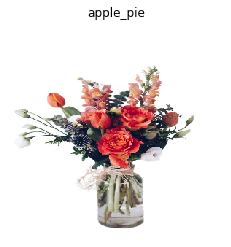

In [10]:
images = []
images.append('/Users/rosetta/Downloads/flower.jpg')
# images.append('/Users/rosetta/Downloads/ob1.jpg')

predict_class(model_best, images, True)